# Pandas — Core Techniques (groupby/transform/explode and more)

This notebook is a practical cheat sheet of core pandas patterns with small, reproducible examples.

**Topics covered**
- Quick data inspection
- Indexing, filtering, and `query`
- Missing values and dtypes
- `groupby`: `agg`, `transform`, `apply`
- `explode` for list-like / JSON-like columns
- Sorting within groups + `shift` (lags)
- Pivot / Melt
- Merge / Join
- Strings and datetimes
- A few performance tips


In [1]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

print("pandas:", pd.__version__)


pandas: 2.3.0


In [2]:
# Create a small reproducible dataset for the examples below

df = pd.DataFrame({
    "user_id":   [1, 1, 1, 2, 2, 3, 3, 3],
    "order_id":  [101, 102, 103, 201, 202, 301, 302, 303],
    "ts": pd.to_datetime([
        "2025-01-01", "2025-01-03", "2025-02-01",
        "2025-01-02", "2025-02-05",
        "2025-01-01", "2025-01-10", "2025-02-11"
    ]),
    "country":   ["AZ", "AZ", "AZ", "TR", "TR", "AZ", "AZ", "TR"],
    "revenue":   [10.0, 20.0, np.nan, 5.0, 30.0, 12.0, 7.0, 9.0],
    "items": [
        ["apple", "banana"],
        ["banana"],
        ["apple", "pear", "pear"],
        ["kiwi"],
        ["kiwi", "banana"],
        [],
        ["banana", "banana"],
        ["pear"]
    ],
    "coupon": [None, "NEW10", None, None, "VIP", None, None, None],
})

df


,user_id,order_id,ts,country,revenue,items,coupon
0,1,101,2025-01-01,AZ,10.0,"[apple, banana]",None
1,1,102,2025-01-03,AZ,20.0,[banana],NEW10
2,1,103,2025-02-01,AZ,NaN,"[apple, pear, pear]",None
3,2,201,2025-01-02,TR,5.0,[kiwi],None
4,2,202,2025-02-05,TR,30.0,"[kiwi, banana]",VIP
5,3,301,2025-01-01,AZ,12.0,[],None
6,3,302,2025-01-10,AZ,7.0,"[banana, banana]",None
7,3,303,2025-02-11,TR,9.0,[pear],None


## 1) Quick data inspection

Common methods:
- `.head()`, `.tail()`, `.sample()`
- `.shape`, `.dtypes`, `.info()`, `.describe()`
- `.value_counts()`, `.nunique()`


In [3]:
df.head(3)

# df.info()
# df.describe(include="all")


,user_id,order_id,ts,country,revenue,items,coupon
0,1,101,2025-01-01,AZ,10.0,"[apple, banana]",None
1,1,102,2025-01-03,AZ,20.0,[banana],NEW10
2,1,103,2025-02-01,AZ,NaN,"[apple, pear, pear]",None


## 2) Indexing and filtering

Useful techniques:
- `.loc` (label-based) vs `.iloc` (position-based)
- boolean masks
- `.query()` for readable filtering


In [4]:
# Select columns
df[["user_id", "order_id", "revenue"]].head()

# Filter with a boolean mask
df[df["revenue"].fillna(0) >= 10]

# Use .query() (@ for external variables)
min_rev = 10
df.query("revenue >= @min_rev")


,user_id,order_id,ts,country,revenue,items,coupon
0,1,101,2025-01-01,AZ,10.0,"[apple, banana]",None
1,1,102,2025-01-03,AZ,20.0,[banana],NEW10
4,2,202,2025-02-05,TR,30.0,"[kiwi, banana]",VIP
5,3,301,2025-01-01,AZ,12.0,[],None


## 3) Missing values and dtypes

- `isna() / notna()`
- `fillna()`, `dropna()`
- `astype()` / `to_numeric()` / `to_datetime()`


In [5]:
df.isna().sum()

# Example: fillna
df2 = df.copy()
df2["revenue_filled"] = df2["revenue"].fillna(0)

# Example: boolean -> integer flag
df2["coupon_is_null"] = df2["coupon"].isna().astype("int8")
df2.head()


,user_id,order_id,ts,country,revenue,items,coupon,revenue_filled,coupon_is_null
0,1,101,2025-01-01,AZ,10.0,"[apple, banana]",None,10.0,1
1,1,102,2025-01-03,AZ,20.0,[banana],NEW10,20.0,0
2,1,103,2025-02-01,AZ,NaN,"[apple, pear, pear]",None,0.0,1
3,2,201,2025-01-02,TR,5.0,[kiwi],None,5.0,1
4,2,202,2025-02-05,TR,30.0,"[kiwi, banana]",VIP,30.0,0


## 4) `explode` — expanding list-like columns into rows

When a column contains lists/arrays, `explode` turns each element into its own row.

Typical use cases:
- order → items
- user → tags/interests
- JSON arrays after parsing


In [6]:
# Note: empty lists become NaN after explode (if kept as [])
df_exploded = df[["order_id", "user_id", "items"]].explode("items", ignore_index=True)
df_exploded.head(10)


,order_id,user_id,items
0,101,1,apple
1,101,1,banana
2,102,1,banana
3,103,1,apple
4,103,1,pear
5,103,1,pear
6,201,2,kiwi
7,202,2,kiwi
8,202,2,banana
9,301,3,NaN


In [7]:
# Example: item frequency
item_counts = (
    df_exploded
    .dropna(subset=["items"])
    .groupby("items", as_index=False)
    .agg(cnt=("order_id", "count"), unique_orders=("order_id", "nunique"))
    .sort_values("cnt", ascending=False)
)

item_counts


,items,cnt,unique_orders
1,banana,5,4
3,pear,3,2
0,apple,2,2
2,kiwi,2,2


## 5) `groupby` — aggregation with `agg`

The classic: sums/means/counts by groups.


In [8]:
# Per-user aggregates (NaNs are ignored by default in sum/mean)
user_agg = (
    df.groupby("user_id", as_index=False)
      .agg(
          orders=("order_id", "nunique"),
          revenue_sum=("revenue", "sum"),
          revenue_mean=("revenue", "mean"),
          first_ts=("ts", "min"),
          last_ts=("ts", "max"),
      )
)

user_agg


,user_id,orders,revenue_sum,revenue_mean,first_ts,last_ts
0,1,3,30.0,15.000000,2025-01-01,2025-02-01
1,2,2,35.0,17.500000,2025-01-02,2025-02-05
2,3,3,28.0,9.333333,2025-01-01,2025-02-11


## 6) `groupby().transform(...)` — aggregate back to rows

`transform` returns a Series with the **same length** as the original DataFrame,
so it's great for adding group-level stats to each row:
- per-user mean revenue
- per-user sum revenue
- per-row share in group total
- within-group normalization (z-score)


In [9]:
df_t = df.copy()

# Per-user mean revenue (broadcast to each row)
df_t["user_rev_mean"] = df_t.groupby("user_id")["revenue"].transform("mean")

# Per-user sum revenue (broadcast to each row)
df_t["user_rev_sum"] = df_t.groupby("user_id")["revenue"].transform("sum")

# Per-row share of user's total revenue
df_t["rev_share_in_user"] = df_t["revenue"] / df_t["user_rev_sum"]

# Z-score within user_id
df_t["rev_z_user"] = (
    (df_t["revenue"] - df_t.groupby("user_id")["revenue"].transform("mean")) /
    df_t.groupby("user_id")["revenue"].transform("std")
)

df_t[["user_id", "order_id", "revenue", "user_rev_mean", "user_rev_sum", "rev_share_in_user", "rev_z_user"]]


,user_id,order_id,revenue,user_rev_mean,user_rev_sum,rev_share_in_user,rev_z_user
0,1,101,10.0,15.000000,30.0,0.333333,-0.707107
1,1,102,20.0,15.000000,30.0,0.666667,0.707107
2,1,103,NaN,15.000000,30.0,NaN,NaN
3,2,201,5.0,17.500000,35.0,0.142857,-0.707107
4,2,202,30.0,17.500000,35.0,0.857143,0.707107
5,3,301,12.0,9.333333,28.0,0.428571,1.059626
6,3,302,7.0,9.333333,28.0,0.250000,-0.927173
7,3,303,9.0,9.333333,28.0,0.321429,-0.132453


## 7) `groupby` + sort + `shift` (lags)

A very common pattern for time-series features at user/item level:
1) sort within key
2) compute lags using `.shift(1)`
3) compute deltas / time gaps


In [10]:
df_lag = df.sort_values(["user_id", "ts"]).copy()

df_lag["prev_revenue"] = df_lag.groupby("user_id")["revenue"].shift(1)
df_lag["revenue_delta"] = df_lag["revenue"] - df_lag["prev_revenue"]
df_lag["days_since_prev"] = (df_lag["ts"] - df_lag.groupby("user_id")["ts"].shift(1)).dt.days

df_lag[["user_id", "order_id", "ts", "revenue", "prev_revenue", "revenue_delta", "days_since_prev"]]


,user_id,order_id,ts,revenue,prev_revenue,revenue_delta,days_since_prev
0,1,101,2025-01-01,10.0,NaN,NaN,NaN
1,1,102,2025-01-03,20.0,10.0,10.0,2.0
2,1,103,2025-02-01,NaN,20.0,NaN,29.0
3,2,201,2025-01-02,5.0,NaN,NaN,NaN
4,2,202,2025-02-05,30.0,5.0,25.0,34.0
5,3,301,2025-01-01,12.0,NaN,NaN,NaN
6,3,302,2025-01-10,7.0,12.0,-5.0,9.0
7,3,303,2025-02-11,9.0,7.0,2.0,32.0


## 8) `groupby().apply(...)` — when you need custom logic

`apply` is powerful but typically slower than `agg/transform`.
Try `agg/transform` first, keep `apply` for genuinely complex logic.


In [11]:
# Example: top-2 orders by revenue per user
def top2_by_revenue(g: pd.DataFrame) -> pd.DataFrame:
    return g.sort_values("revenue", ascending=False).head(2)

top2 = (
    df.dropna(subset=["revenue"])
      .groupby("user_id", group_keys=False)
      .apply(top2_by_revenue)
)

top2[["user_id", "order_id", "revenue"]]


/var/folders/zq/dhc8psjn589_khvwcn4lfc6w0000gn/T/ipykernel_9871/3284450621.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(top2_by_revenue)


,user_id,order_id,revenue
1,1,102,20.0
0,1,101,10.0
4,2,202,30.0
3,2,201,5.0
5,3,301,12.0
7,3,303,9.0


## 9) Pivot / Melt

- `pivot_table` — reshape to a wide format
- `melt` — reshape back to long format


In [12]:
# Pivot: revenue sum by country and month
df_p = df.copy()
df_p["month"] = df_p["ts"].dt.to_period("M").astype(str)

pvt = pd.pivot_table(
    df_p,
    index="month",
    columns="country",
    values="revenue",
    aggfunc="sum",
    fill_value=0
)

pvt


country,AZ,TR
month,,
2025-01,49.0,5.0
2025-02,0.0,39.0


In [13]:
pvt_reset = pvt.reset_index()
long = pvt_reset.melt(id_vars=["month"], var_name="country", value_name="revenue_sum")
long


,month,country,revenue_sum
0,2025-01,AZ,49.0
1,2025-02,AZ,0.0
2,2025-01,TR,5.0
3,2025-02,TR,39.0


## 10) Merge / Join

Common ways to combine tables:
- `how='left'|'inner'|'right'|'outer'`
- `validate=` is super useful to catch unexpected duplicates


In [14]:
users = pd.DataFrame({
    "user_id": [1, 2, 3],
    "age": [30, 25, 28],
    "segment": ["A", "B", "A"]
})

df_joined = df.merge(users, on="user_id", how="left", validate="many_to_one")
df_joined.head()


,user_id,order_id,ts,country,revenue,items,coupon,age,segment
0,1,101,2025-01-01,AZ,10.0,"[apple, banana]",None,30,A
1,1,102,2025-01-03,AZ,20.0,[banana],NEW10,30,A
2,1,103,2025-02-01,AZ,NaN,"[apple, pear, pear]",None,30,A
3,2,201,2025-01-02,TR,5.0,[kiwi],None,25,B
4,2,202,2025-02-05,TR,30.0,"[kiwi, banana]",VIP,25,B


## 11) Strings and datetimes

- `.str.*` for string operations
- `.dt.*` for datetime operations


In [15]:
df_s = df.copy()

df_s["coupon_lower"] = df_s["coupon"].fillna("").str.lower()
df_s["weekday"] = df_s["ts"].dt.day_name()
df_s["is_weekend"] = df_s["ts"].dt.weekday >= 5

df_s[["order_id", "coupon", "coupon_lower", "ts", "weekday", "is_weekend"]]


,order_id,coupon,coupon_lower,ts,weekday,is_weekend
0,101,None,,2025-01-01,Wednesday,False
1,102,NEW10,new10,2025-01-03,Friday,False
2,103,None,,2025-02-01,Saturday,True
3,201,None,,2025-01-02,Thursday,False
4,202,VIP,vip,2025-02-05,Wednesday,False
5,301,None,,2025-01-01,Wednesday,False
6,302,None,,2025-01-10,Friday,False
7,303,None,,2025-02-11,Tuesday,False


## 12) Categorical dtype

Using `category` can reduce memory usage and speed up some operations (groupby, joins, value_counts) on large datasets.


In [16]:
df_cat = df.copy()
df_cat["country"] = df_cat["country"].astype("category")
df_cat.dtypes


user_id              int64
order_id             int64
ts          datetime64[ns]
country           category
revenue            float64
items               object
coupon              object
dtype: object

## 13) Performance tips (quick)

- Prefer `agg/transform` over `apply` when possible
- Avoid Python loops over rows; vectorize instead
- On big data: consider `category`, and narrower integer dtypes when safe (`int32` vs `int64`)
- If you reuse a complex filter, store the boolean mask
- For `merge` and `groupby`, duplicates in keys can change results—use `validate=` to catch issues early


## 14)`explode` + `groupby.transform` together

Example: for each order, compute:
- number of items in the order
- share of each item among all items of the user


In [17]:
dfx = df[["user_id", "order_id", "items"]].explode("items", ignore_index=True)
dfx = dfx.dropna(subset=["items"]).copy()

# Number of items in the order
dfx["items_in_order"] = dfx.groupby("order_id")["items"].transform("count")

# Count of each item within a user
dfx["item_cnt_in_user"] = dfx.groupby(["user_id", "items"])["order_id"].transform("count")

# Total item occurrences within a user (including repeats)
dfx["total_items_in_user"] = dfx.groupby("user_id")["items"].transform("count")

# Share of the item among all items of the user
dfx["item_share_in_user"] = dfx["item_cnt_in_user"] / dfx["total_items_in_user"]

dfx.head(15)


,user_id,order_id,items,items_in_order,item_cnt_in_user,total_items_in_user,item_share_in_user
0,1,101,apple,2,2,6,0.333333
1,1,101,banana,2,2,6,0.333333
2,1,102,banana,1,2,6,0.333333
3,1,103,apple,3,2,6,0.333333
4,1,103,pear,3,2,6,0.333333
5,1,103,pear,3,2,6,0.333333
6,2,201,kiwi,1,2,3,0.666667
7,2,202,kiwi,2,2,3,0.666667
8,2,202,banana,2,1,3,0.333333
10,3,302,banana,2,2,3,0.666667


In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
a = np.random.normal(0, 1, 10000)   
b = np.random.normal(0, 1, 1000)   

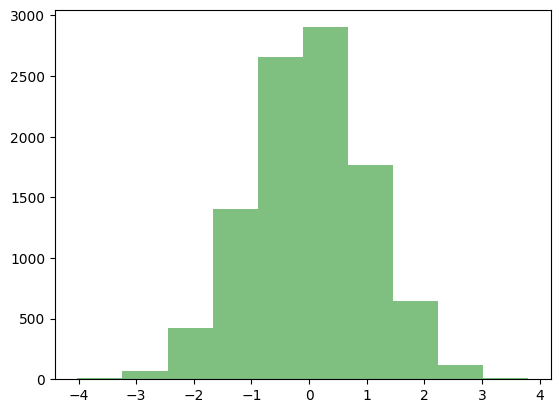

In [7]:
plt.hist(a, alpha=0.5, color='g')
plt.show()

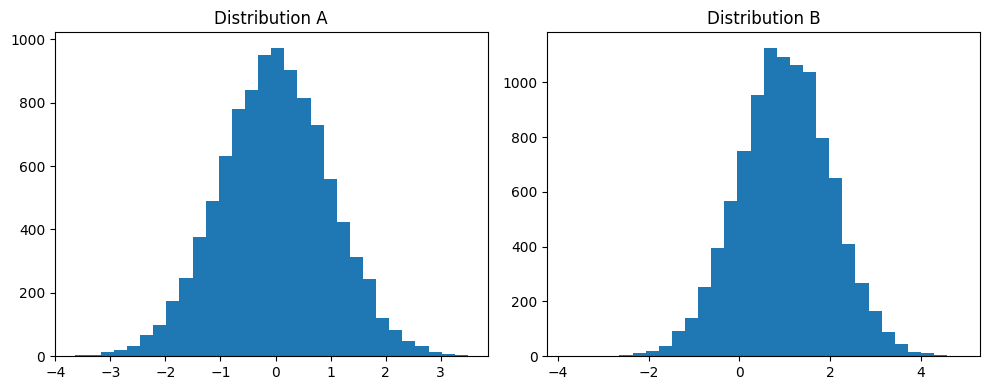

In [14]:
a = np.random.normal(0, 1, 10000)
b = np.random.normal(1, 1, 10000)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))  

axes[0].hist(a, bins=30)
axes[0].set_title("Distribution A")

axes[1].hist(b, bins=30)
axes[1].set_title("Distribution B")

plt.tight_layout()
plt.show()